## Lab Assignment Seven: Sequential Network Architectures

Team: Katie Laird, Cameron Miller, Will Landin

Dataset: 

Select a dataset that is text. That is, the dataset should be text data. In terms of generalization performance, it is helpful to have a medium sized dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification should be "many-to-one" sequence classification.

Dataset: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/

In [167]:
import numpy as np
import pandas as pd
import re
import gc

### Preparation

[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence. 

In [168]:
# read in the dataset as a pandas dataframe
df = pd.read_csv("Datasets/Corona_NLP.csv",encoding='latin1')
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2/3/2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",3/3/2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


### Clean The Corona Tweets dataset

In [169]:
def clean_tweet(tweet):
    # Remove any non-alphabetic characters except basic punctuation
    tweet = re.sub(r"[^a-zA-Z0-9.,'!? ]", '', tweet)
    # Remove any excess whitespace
    tweet = re.sub(r"\s+", ' ', tweet).strip()
    return tweet

In [170]:

df['OriginalTweet'] = df['OriginalTweet'].apply(clean_tweet)
df.head(5)

print (df.value_counts('Sentiment'))
label_counts = df['Sentiment'].value_counts()


Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
dtype: int64


#### One Hot Encode Sentiments

In [171]:
df = pd.read_csv("Datasets/Corona_NLP.csv",encoding='latin1')
df['OriginalTweet'] = df['OriginalTweet'].apply(clean_tweet)

df['Sentiment'] = df['Sentiment'].replace('Extremely Negative', 0)
df['Sentiment'] = df['Sentiment'].replace('Negative', 0)
df['Sentiment'] = df['Sentiment'].replace('Neutral', 1)
df['Sentiment'] = df['Sentiment'].replace('Positive', 2)
df['Sentiment'] = df['Sentiment'].replace('Extremely Positive', 2)

print (df.value_counts('Sentiment'))



Sentiment
2    19592
0    17031
1     8332
dtype: int64


In [172]:
df_negative = df[df['Sentiment'] == 0]
df_neutral = df[df['Sentiment'] == 1]
df_positive = df[df['Sentiment'] == 2]

df_negative_sampled = df_negative.sample(n=min(8332, len(df_negative)), random_state=42)
df_neutral_sampled = df_neutral.sample(n=min(8332, len(df_neutral)), random_state=42)
df_positive_sampled = df_positive.sample(n=min(8332, len(df_positive)), random_state=42)

# Concatenate the sampled dataframes
df_undersampled = pd.concat([df_negative_sampled, df_neutral_sampled, df_positive_sampled])

# Optionally, shuffle the dataframe
df_undersampled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

df = df_undersampled

df.value_counts('Sentiment')

Sentiment
0    8332
1    8332
2    8332
dtype: int64

In [173]:

#delete the negative, neutral, positive, and undersampled dataframes to help with memory
del df_negative, df_neutral, df_positive, df_negative_sampled, df_neutral_sampled, df_positive_sampled, df_undersampled

gc.collect()

11114

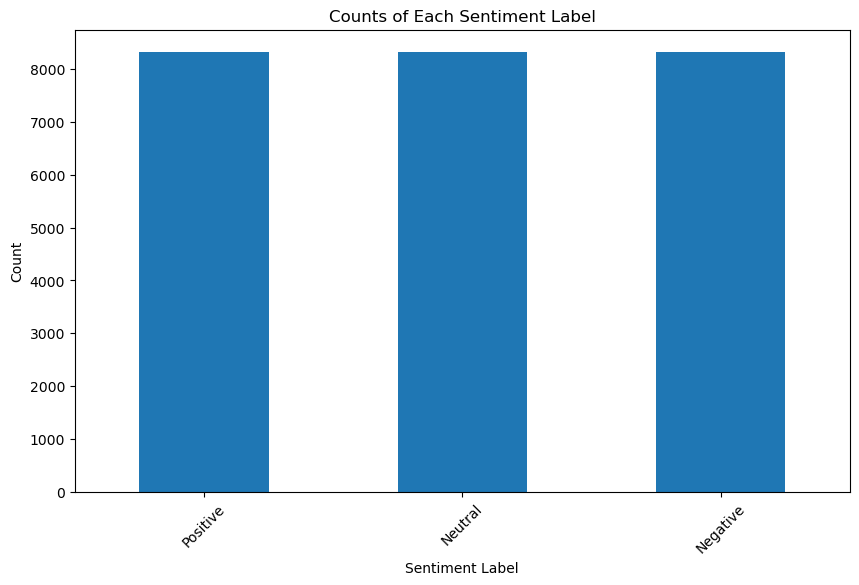

In [174]:
import matplotlib.pyplot as plt

label_counts = df['Sentiment'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Counts of Each Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Positive', 'Neutral', 'Negative'], rotation=45)
plt.show()

In [175]:
avg_length = np.mean([len(tweet) for tweet in df['OriginalTweet']])
max_length = np.max([len(tweet) for tweet in df['OriginalTweet']])
min_length = np.min([len(tweet) for tweet in df['OriginalTweet']])
print(f"Average length of tweets: {avg_length:.2f} Characters")
print(f"Max length of tweets: {max_length} Characters")
print(f"Min length of tweets: {min_length} Characters")

Average length of tweets: 188.47 Characters
Max length of tweets: 315 Characters
Min length of tweets: 3 Characters


### Train Test split data

(19996,) (5000,) (19996,) (5000,)
X_train Shape: (19996,) Label Shape: (19996,)


NameError: name 'bunch' is not defined

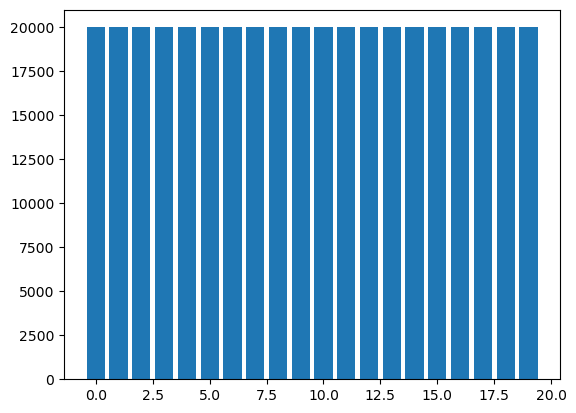

In [176]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train.shape)
uniq_classes = np.sum(y_train,axis=0)
plt.bar(list(range(20)),uniq_classes)
plt.xticks(list(range(20)), bunch.target_names, rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 

### Modeling

http://nlp.stanford.edu/data/glove.6B.zip

ensure you have the glove embeddings downloaded

In [177]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../glove/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# # now fill in the matrix, using the ordering from the
# #  keras word tokenizer from before
# found_words = 0
# embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be ALL-ZEROS
#         embedding_matrix[i] = embedding_vector
#         found_words = found_words+1

# print("Embedding Shape:",embedding_matrix.shape, "\n",
#       "Total words found:",found_words, "\n",
#       "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
CPU times: user 3.88 s, sys: 180 ms, total: 4.06 s
Wall time: 3.75 s


[3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

In [178]:
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

NameError: name 'Layer' is not defined

[1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations.

[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

### Exceptional Work

[1 points] Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application? 